In [20]:
import pandas as pd

def print_results_table(csv_results_path, methods):
    # Import required libraries
    

    # Load the CSV data (replace with your actual path if reading from file)

    df = pd.read_csv(csv_results_path,sep='\t')
    # Pivot table: datasets in rows, methods as columns, MAE as values
    mae_table = df.pivot(index='Dataset', columns='Method', values='MAE')

    # filter table so only methods in methods are shown (methods is a tuple)
    mae_table = mae_table[mae_table.columns[mae_table.columns.isin(methods)]]
    # reindex using methods
    mae_table = mae_table.reindex(columns=methods)

    # Function to bold the minimum value in each row
    def highlight_best(s):
        is_min = s == s.min()
        return ['font-weight: bold' if v else '' for v in is_min]

    # Add a row with mean MAE per method
    mae_table.loc['Mean'] = mae_table.mean()

    # Apply the highlighting
    styled = mae_table.style.apply(highlight_best, axis=1).format("{:.4f}")

    # Display the styled table
    return styled

In [21]:
import pandas as pd
import numpy as np

def value_to_cellcolor_vs_ref(val, ref, row_min, row_max,
                              lower_is_better=True, maxtone=200,
                              norm_mode='rel', min_denom_eps=1e-12):
    """
    Map a value to a LaTeX \cellcolor comparing to a reference value (ref).

    norm_mode:
      - 'range'   : (default old behavior) denom = row_max - row_min
      - 'maxdist' : denom = max(|ref-row_min|, |ref-row_max|)  <-- recommended
      - 'rel'     : denom = ref (use relative percent improvement)
    min_denom_eps avoids division by zero.

    Returns a string: either plain "val" or "\cellcolor{green!tone}val" / red.
    """
    # Format to 4 decimals
    fmt = f"{val:.4f}"

    # Choose denominator according to normalization mode
    if norm_mode == 'range':
        denom = row_max - row_min
    elif norm_mode == 'maxdist':
        denom = max(abs(ref - row_min), abs(ref - row_max))
    elif norm_mode == 'rel':
        denom = abs(ref)
    else:
        raise ValueError(f"Unknown norm_mode: {norm_mode}")

    # Avoid tiny/zero denom
    if denom is None or denom <= min_denom_eps:
        return fmt

    # Compute signed normalized difference
    if lower_is_better:
        diff_norm = (ref - val) / denom
    else:
        diff_norm = (val - ref) / denom

    # Clip to [-1, 1]
    diff_norm = np.clip(diff_norm, -1.0, 1.0)

    tone = int(round(maxtone * abs(diff_norm)))
    if tone == 0:
        return fmt

    color = "green" if diff_norm > 0 else "red"
    return f"\\cellcolor{{{color}!{tone}}}{fmt}"

def remove_trailing_zeros(latex_code):
    return latex_code.replace("0.",".")

def export_results_to_latex(csv_results_path, methods, method_names=None):
    # Load the CSV data
    df = pd.read_csv(csv_results_path, sep='\t')
    
    # Pivot table: datasets in rows, methods as columns, MAE as values
    mae_table = df.pivot(index='Dataset', columns='Method', values='MAE')
    
    # Filter to include only specified methods
    mae_table = mae_table[mae_table.columns[mae_table.columns.isin(methods)]]
    # reindex using methods
    mae_table = mae_table.reindex(columns=methods)

    if method_names is not None:
        # Rename the columns using method_names
        mae_table.columns = method_names
    
    # Add a row with mean MAE per method
    mae_table.loc['Mean'] = mae_table.mean()
    
    # Apply bold formatting to the minimum value in each row
    formatted_rows = []
    for idx, row in mae_table.iterrows():
        min_val = min(row)
        row_min = row.min()
        row_max = row.max()
        is_min = []
        for i, v in enumerate(row):
            if i == 0 and v == min_val:
                # baseline is tied with the minimum → bold only baseline
                is_min.append(True)
            elif v == min_val and row[0] != min_val:
                # baseline is not minimum → bold all other minimums
                is_min.append(True)
            else:
                is_min.append(False)

        formated_row = []
        ref = row.iloc[0]
        for col_idx,(v,m) in enumerate(zip(row,is_min)):

            if idx != "Mean":
                if col_idx == 0:
                    # Baseline cell: always white (no \cellcolor)
                    cell = f"{v:.4f}"
                else:
                    cell = value_to_cellcolor_vs_ref(v, ref, row_min, row_max, lower_is_better=True)
            else:
                cell = f"{v:.4f}"
            if m:
                cell = f"\\textbf{{{cell}}}"
            formated_row.append(cell)
        formatted_rows.append(formated_row)
    
    formatted_table = pd.DataFrame(formatted_rows, index=mae_table.index, columns=mae_table.columns)
    formatted_table.index = formatted_table.index.str.replace('_', '\\_', regex=False)

    # Group info
    header_groups = [
        ("Baseline", 2),
        ("E-step mods", 2),
        ("M-step mods", 4)
    ]

    # Build column format (no trailing |)
    column_format = "l"
    for i, (_, count) in enumerate(header_groups):
        column_format += "|" + "c" * count if i > 0 else "c" * count

    # Start LaTeX table
    latex_lines = []
    latex_lines.append(f"\\begin{{tabular}}{{{column_format}}}")
    latex_lines.append("\\toprule")

    # First header row: method groups
    header_line1 = [""]  # Dataset column
    for i, (group_name, count) in enumerate(header_groups):
        group_spec = "c" if i == len(header_groups) - 1 else "c|"
        header_line1.append(f"\\multicolumn{{{count}}}{{{group_spec}}}{{{group_name}}}")
    latex_lines.append(" & ".join(header_line1) + " \\\\")

    # Second header row: method names
    header_line2 = [""] + list(formatted_table.columns)
    latex_lines.append(" & ".join(header_line2) + " \\\\")
    latex_lines.append("\\midrule")

    # Table body
    for idx, row in formatted_table.iterrows():
        if idx == "Mean":
            latex_lines.append("\\hline")
        line = [idx] + list(row)
        latex_lines.append(" & ".join(line) + " \\\\")

    latex_lines.append("\\bottomrule")
    latex_lines.append("\\end{tabular}")

    output = "\n".join(latex_lines)
    output=output.replace("academic-success","acam-success")
    output = remove_trailing_zeros(output)
    
    return output


## Multiclass results

In [22]:
def get_em_variations(classifier):
    """
    Returns a tuple of EM variations for the given classifier.
    """
    return (
        f'EM_{classifier}',
        f'EM_BCTS_{classifier}',
        f'PSEM_{classifier}',
        f'TSEM_{classifier}',
        f'DEM_{classifier}',
        f'EREM_{classifier}',
        f'DMAPEM_{classifier}',
        f'CSEM_{classifier}',
    )
    

for classifier in ('LR',):
    display(print_results_table('results/ucimulti2/allmethods.csv',get_em_variations(classifier)))



Method,EM_LR,EM_BCTS_LR,PSEM_LR,TSEM_LR,DEM_LR,EREM_LR,DMAPEM_LR,CSEM_LR
Dataset,,,,,,,,
abalone,0.0707,0.0746,0.0510,0.0515,0.0540,0.0573,0.0509,0.0707
academic-success,0.0307,0.0318,0.0307,0.0307,0.0307,0.0307,0.0415,0.0307
chess,0.0356,0.0352,0.0302,0.0328,0.0301,0.0356,0.0290,0.0356
cmc,0.0946,0.1126,0.1050,0.0946,0.0897,0.0946,0.1048,0.0946
connect-4,0.0365,0.0349,0.0347,0.0365,0.0333,0.0365,0.0340,0.0365
digits,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027
dry-bean,0.0043,0.0041,0.0042,0.0043,0.0042,0.0043,0.0043,0.0043
hand_digits,0.0029,0.0029,0.0029,0.0029,0.0028,0.0029,0.0029,0.0029
hcv,0.2078,0.3041,0.1683,0.1666,0.1923,0.1623,0.1703,0.2078


In [23]:
output = export_results_to_latex('results/ucimulti2/allmethods.csv',('EM_LR','EM_BCTS_LR','PSEM_LR','TSEM_LR','DMAPEM_LR','DEM_LR','CSEM_LR','EREM_LR'),('EMQ','Calib','Smooth','Temp','MAP','Damp','Conf','Ent'))
with open("paper/multiclass_lr.tex", "w") as f:
    f.write(output)
#print(export_results_to_latex('results/ucimulti/allmethods.csv',('EM_NN','EM_BCTS_NN','PSEM_NN','TSEM_NN','DMAPEM_NN','DEM_NN','CSEM_NN','EREM_NN'),('EMQ','Calib','Smooth','Temp','MAP','Damp','Conf','Ent')))

/tmp/ipykernel_4129469/4431625.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif v == min_val and row[0] != min_val:


In [35]:
def get_em_variations(classifier):
    """
    Returns a tuple of EM variations for the given classifier.
    """
    return (
        f'EM_{classifier}',
        f'TSEM_DEM_{classifier}',
        f'TSEM_EREM_{classifier}',
        f'TSEM_DMAPEM_{classifier}',
        f'PSEM_DEM_{classifier}',
        f'PSEM_EREM_{classifier}',
        f'PSEM_DMAPEM_{classifier}',
    )
    

for classifier in ('LR',):
    display(print_results_table('results/ucimulti2/allmethods.csv',get_em_variations(classifier)))



Method,EM_LR,TSEM_DEM_LR,TSEM_EREM_LR,TSEM_DMAPEM_LR,PSEM_DEM_LR,PSEM_EREM_LR,PSEM_DMAPEM_LR
Dataset,,,,,,,
abalone,0.0707,0.0515,0.0515,0.0509,0.0510,0.0510,0.0510
academic-success,0.0307,0.0307,0.0307,0.0415,0.0404,0.0307,0.0399
chess,0.0356,0.0301,0.0328,0.0290,0.0295,0.0302,0.0290
cmc,0.0946,0.0897,0.0946,0.1048,0.1050,0.1050,0.1048
connect-4,0.0365,0.0333,0.0365,0.0340,0.0340,0.0347,0.0340
digits,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027
dry-bean,0.0043,0.0042,0.0043,0.0043,0.0042,0.0042,0.0042
hand_digits,0.0029,0.0028,0.0029,0.0029,0.0028,0.0029,0.0029
hcv,0.2078,0.1923,0.1666,0.1703,0.1809,0.1683,0.1865


In [25]:
import pandas as pd
import numpy as np

def export_results_to_latex(csv_results_path, methods, method_names=None):
    # Load the CSV data
    df = pd.read_csv(csv_results_path, sep='\t')
    
    # Pivot table: datasets in rows, methods as columns, MAE as values
    mae_table = df.pivot(index='Dataset', columns='Method', values='MAE')
    
    # Keep only desired methods and in the requested order
    mae_table = mae_table.loc[:, mae_table.columns.isin(methods)]
    mae_table = mae_table.reindex(columns=methods)

    # Optional rename
    if method_names is not None:
        mae_table.columns = method_names
    
    # Add mean row
    mae_table.loc['Mean'] = mae_table.mean()
    
    # Bold formatting with your baseline-tie rule
    formatted_rows = []
    for idx, row in mae_table.iterrows():
        min_val = np.nanmin(row.values.astype(float))
        row_min = row.min()
        row_max = row.max()

        is_min = []
        for i, v in enumerate(row):
            if i == 0 and v == min_val:
                is_min.append(True)                # baseline tied → bold baseline only
            elif v == min_val and row[0] != min_val:
                is_min.append(True)                # baseline not min → bold all mins
            else:
                is_min.append(False)


        formated_row = []
        ref = row.iloc[0]
        for col_idx,(v,m) in enumerate(zip(row,is_min)):

            if idx != "Mean":
                if col_idx == 0:
                    # Baseline cell: always white (no \cellcolor)
                    cell = f"{v:.4f}"
                else:
                    cell = value_to_cellcolor_vs_ref(v, ref, row_min, row_max, lower_is_better=True)
            else:
                cell = f"{v:.4f}"
            if m:
                cell = f"\\textbf{{{cell}}}"
            formated_row.append(cell)
        formatted_rows.append(formated_row)
        
    
    formatted_table = pd.DataFrame(formatted_rows, index=mae_table.index, columns=mae_table.columns)
    formatted_table.index = formatted_table.index.str.replace('_', '\\_', regex=False)

    # --- SIMPLE HEADER (no groups) ---
    # Booktabs style: no vertical rules
    column_format = "l" + "c" * len(formatted_table.columns)

    latex_lines = []
    latex_lines.append(f"\\begin{{tabular}}{{{column_format}}}")
    latex_lines.append("\\toprule")

    # Single header row: method names
    header_line = [""] + list(formatted_table.columns)
    latex_lines.append(" & ".join(header_line) + " \\\\")
    latex_lines.append("\\midrule")

    # Body
    for idx, row in formatted_table.iterrows():
        if idx == "Mean":
            latex_lines.append("\\hline")
        line = [idx] + list(row)
        latex_lines.append(" & ".join(line) + " \\\\")

    latex_lines.append("\\bottomrule")
    latex_lines.append("\\end{tabular}")

    output = "\n".join(latex_lines)
    output=output.replace("academic-success","acam-success")
    output = remove_trailing_zeros(output)
    return output


In [26]:
output = export_results_to_latex('results/ucimulti2/allmethods.csv',('EM_LR','PSEM_DEM_LR','PSEM_EREM_LR','PSEM_DMAPEM_LR','TSEM_DEM_LR','TSEM_EREM_LR','TSEM_DMAPEM_LR'),('EMQ','SmoothDamp','SmoothEnt','SmoothMAP','TempDamp','TempEnt','TempMAP'))
with open("paper/combinations_lr.tex", "w") as f:
    f.write(output)

#print(export_results_to_latex('results/ucimulti/allmethods.csv',('EM_NN','TSEM_DEM_NN','TSEM_EREM_NN','TSEM_DMAPEM_NN','PSEM_DEM_NN','PSEM_EREM_NN','PSEM_DMAPEM_NN'),('EMQ','SmoothDamp','SmoothEnt','SmoothMAP','TempDamp','TempEnt','TempMAP')))

/tmp/ipykernel_4129469/2017143569.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif v == min_val and row[0] != min_val:


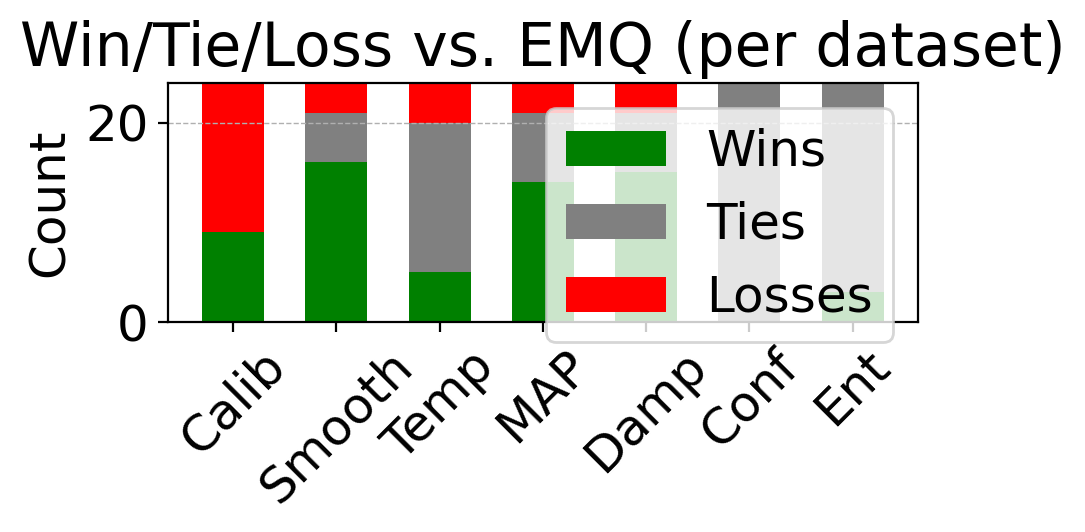

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_win_tie_loss(exp, csv_results_path, method_names, display_labels, baseline_method, tie_tolerance=1e-6):
    """
    Generate a stacked bar chart showing win/tie/loss counts per method vs. baseline (EMQ).

    Parameters:
        csv_results_path (str): Path to the CSV file.
        method_names (list): List of method IDs to evaluate (excluding baseline).
        display_labels (list): Labels to show on the x-axis.
        baseline_method (str): Method name used as the baseline for comparison.
        tie_tolerance (float): Allowed tolerance for ties.
    """
    assert len(method_names) == len(display_labels), "Method names and labels must match"

    # Load and pivot data
    df = pd.read_csv(csv_results_path, sep='\t')
    df = df[df['Method'].isin(method_names + [baseline_method])]
    pivot = df.pivot(index='Dataset', columns='Method', values='MAE')

    # Initialize counters
    wins, ties, losses = [], [], []

    for m in method_names:
        diff = pivot[baseline_method] - pivot[m]
        wins.append((diff > tie_tolerance).sum())
        ties.append((diff.abs() <= tie_tolerance).sum())
        losses.append((diff < -tie_tolerance).sum())

    # Create bar chart
    x = np.arange(len(display_labels))
    width = 0.6

    plt.figure(figsize=(5, 3))
    plt.bar(x, wins, width, label='Wins', color='green')
    plt.bar(x, ties, width, bottom=wins, label='Ties', color='gray')
    plt.bar(x, losses, width, bottom=np.array(wins)+np.array(ties), label='Losses', color='red')

    plt.xticks(x, display_labels, rotation=45)
    plt.ylabel("Count")
    plt.title("Win/Tie/Loss vs. EMQ (per dataset)")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.savefig("win_tie_loss_summary_{}.pdf".format(exp), format="pdf", bbox_inches="tight")
    plt.show()


methods = ['EM_LR','EM_BCTS_LR','PSEM_LR','TSEM_LR','DMAPEM_LR','DEM_LR','CSEM_LR','EREM_LR']
labels = ['EMQ','Calib','Smooth','Temp','MAP','Damp','Conf','Ent']
methods_no_emq = methods[1:]
labels_no_emq = labels[1:]

plot_win_tie_loss(
    'LR',
    'results/ucimulti2/allmethods.csv',
    methods_no_emq,
    labels_no_emq,
    baseline_method=methods[0]  # e.g., 'EM_LR'
)


In [28]:
import quapy as qp
import os

clf = 'LR'
DATA_DIR = "results/ucimulti2"
datasets = qp.datasets.UCI_MULTICLASS_DATASETS
methods = ['EM','DMAPEM','TSEM','PSEM','EREM','DEM']
method_names = {'EM':'EM','DMAPEM':'MAP','TSEM':'Temp','PSEM':'Smooth','EREM':'Ent','DEM':'Damp'}



p = []
p_hat = []
training = []
methods_ = []

for method in methods:
    for dataset in datasets:
        filename = f"{method}_{clf}_{dataset}.dataframe"
        filepath = os.path.join(DATA_DIR, filename)
        if not os.path.exists(filepath):
            print(f"[!] Missing file: {filename}")
            continue
        results = qp.util.load_report(filepath, as_dict=True)
        p.append(results['true-prev'])
        p_hat.append(results['estim-prev'])
        training.append(qp.datasets.fetch_UCIMulticlassDataset(dataset).training.prevalence())
        methods_.append(method)

methods__ = []
for m in methods_:
    methods__.append(method_names[m])
        

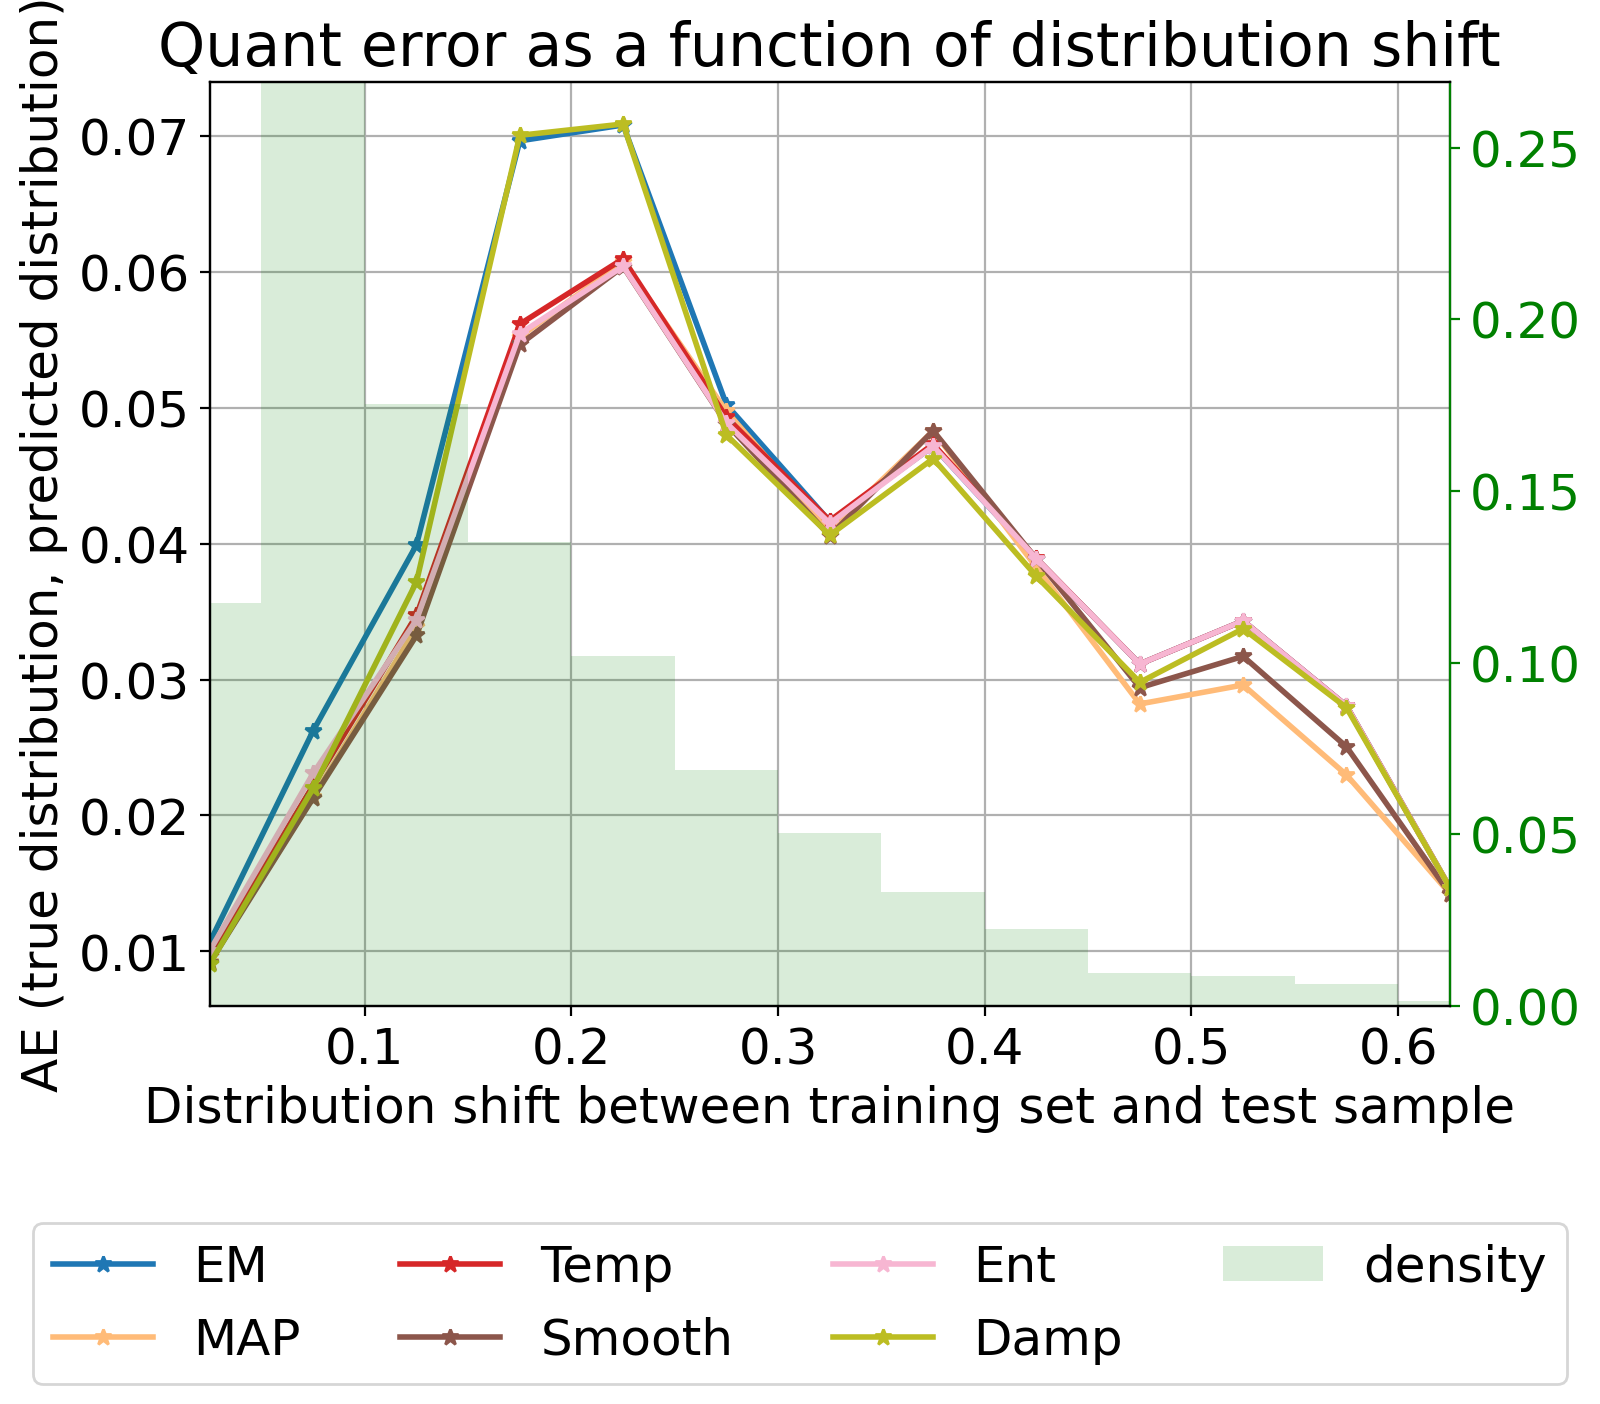

In [29]:
fig = qp.plot.error_by_drift(methods__, p, p_hat, tr_prevs=training,
    error_name='ae', n_bins=20, savepath='./paper/err_drift.png',method_order=list(method_names.values()),show_std=False,title=f'Quant error as a function of distribution shift')

In [30]:
import pickle
import quapy as qp
import os

clf = 'LR'
datasets = qp.datasets.UCI_MULTICLASS_DATASETS
methods = ['PSEM','TSEM','DEM','EREM','DMAPEM','CSEM']
hyperparameters=['tau','lambd','epsilon_smoothing','alpha','eta','kappa']

hyperparam_values = {h: [] for h in hyperparameters}


for dataset in datasets:
    for method in methods:
        filename = f"{method}_{clf}_{dataset}.pkl"
        filepath = os.path.join('bestparams', filename)
        with open(filepath, 'rb') as f:
            loaded_dict = pickle.load(f)
            for h in hyperparameters:
                if h in loaded_dict:
                    hyperparam_values[h].append(loaded_dict[h])
print(hyperparam_values)

{'tau': [1.0, 1.0, 1.0, 1.0, 1.25, 1.25, 1.25, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 0.75, 1.0, 1.25, 1.0, 1.0, 1.25, 1.0, 1.0, 1.25, 1.25], 'lambd': [np.float64(0.5), np.float64(0.1), np.float64(1.0), np.float64(0.2), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(1.0), np.float64(0.5), np.float64(0.5), np.float64(0.2), np.float64(1.0), np.float64(0.1), np.float64(0.2), np.float64(0.2), np.float64(0.1), np.float64(0.4), np.float64(0.1), np.float64(0.1), np.float64(0.1), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.1)], 'epsilon_smoothing': [0.0001, 0.001, 0, 0.0001, 0.001, 0.01, 0.001, 1e-05, 0.001, 0, 0.001, 0.01, 0.01, 1e-06, 0.001, 0.001, 0.01, 0.001, 0.001, 0.001, 0.001, 0.01, 0, 0.01], 'alpha': [1.0, 2.0, 2.0, 1.0, 2.0, 5.0, 2.0, 1.0, 1.0, 1.0, 2.0, 5.0, 5.0, 1.0, 2.0, 2.0, 10.0, 2.0, 2.0, 2.0, 2.0, 5.0, 1.0, 5.0], 'eta': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001

In [36]:
import pickle
import quapy as qp
import os

clf = 'LR'
datasets = qp.datasets.UCI_MULTICLASS_DATASETS
methods = ['PSEM_EREM']
hyperparameters=['tau','lambd','epsilon_smoothing','alpha','eta','kappa']

hyperparam_values = {h: [] for h in hyperparameters}


for dataset in datasets:
    for method in methods:
        filename = f"{method}_{clf}_{dataset}.pkl"
        filepath = os.path.join('bestparams', filename)
        with open(filepath, 'rb') as f:
            loaded_dict = pickle.load(f)
            for h in hyperparameters:
                if h in loaded_dict:
                    hyperparam_values[h].append(loaded_dict[h])
print(hyperparam_values)

{'tau': [], 'lambd': [], 'epsilon_smoothing': [0.0001, 0.001, 0, 0.0001, 0.001, 0.01, 0.001, 1e-05, 0.001, 0, 0.001, 0.01, 0.01, 1e-06, 0.001, 0.001, 0.01, 0.001, 0.001, 0.001, 0.001, 0.01, 0, 0.01], 'alpha': [], 'eta': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'kappa': []}


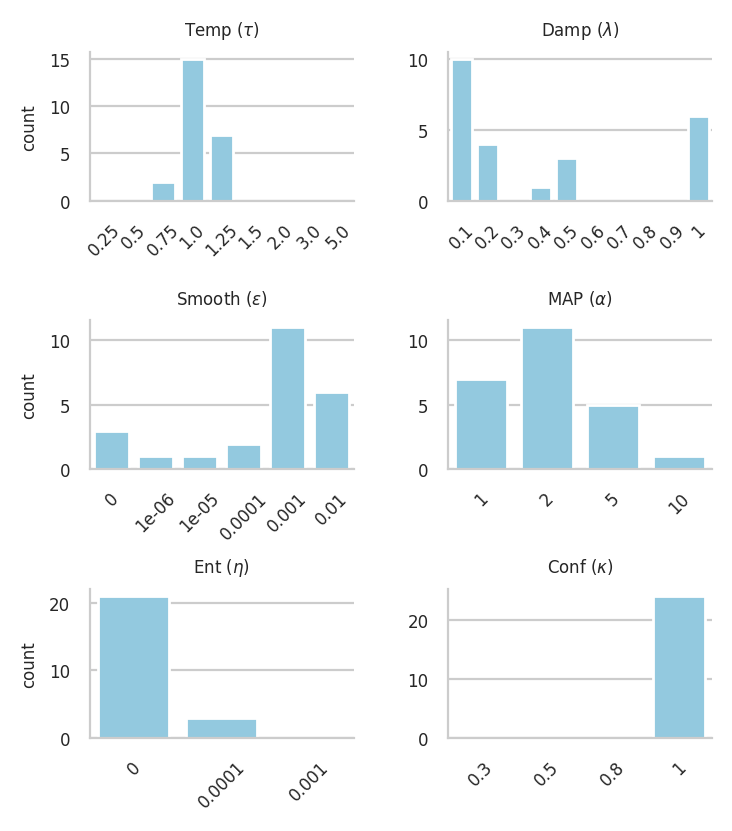

In [31]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def hp_count_bars(hp_data, tested_values, display_names=None, ncols=2, figsize=None, fontsize=6):
    """
    Plot vertical bar charts for each hyperparameter showing counts of tested values.
    Args:
      hp_data: dict {param_name: list_of_values} or list of dicts (per-experiment records)
      tested_values: dict {param_name: list_of_all_values_you_expected}
                     (defines x-axis values; missing ones shown with 0 counts)
      display_names: optional dict {param_name: label_to_display_on_plot}
                     (use raw strings with mathtext, e.g. r'$\lambda$')
      ncols: number of columns in the grid
      figsize: tuple (w, h). If None it is auto-sized.
      fontsize: base fontsize for titles and ticks
    """
    sns.set_style("whitegrid")

    # Normalize hp_data into a DataFrame
    if isinstance(hp_data, list):
        df = pd.DataFrame(hp_data)
    else:  # dict of lists
        df = pd.DataFrame(dict((k, pd.Series(v)) for k, v in hp_data.items()))

    display_names = display_names or {}
    params = list(tested_values.keys())
    n = len(params)
    nrows = math.ceil(n / ncols)

    if figsize is None:
        figsize = (2 * ncols, 1.5 * nrows)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, squeeze=True)
    axes = axes.flatten()

    for i, param in enumerate(params):
        ax = axes[i]
        series = df[param].dropna()
        observed_counts = series.value_counts()

        # Ensure counts are aligned to the supplied tested_values list (missing -> 0)
        final_counts = observed_counts.reindex(tested_values[param], fill_value=0)

        # Use string labels so things like 1e-6 appear nicely; keep numeric order from tested_values
        x_labels = [str(x) for x in tested_values[param]]
        sns.barplot(x=x_labels, y=final_counts.values, ax=ax, color="skyblue", order=x_labels)

        # title / label (use display_names if provided; mathtext works if you pass e.g. r'$\lambda$')
        title = display_names.get(param, param)
        ax.set_title(title, fontsize=fontsize)

        ax.set_xlabel("")
        # Remove y-label on right-most column to save space
        if (i % ncols) == (ncols - 1):
            ax.set_ylabel("")   # no 'count' on the right-most plots
        else:
            ax.set_ylabel("count", fontsize=max(fontsize-1, 6))

        ax.tick_params(axis="x", labelrotation=45, labelsize=max(fontsize-1, 6))
        ax.tick_params(axis="y", labelsize=max(fontsize-1, 6))
        sns.despine(ax=ax, top=True, right=True)

    # turn off unused axes (if any)
    for j in range(n, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.8)
    plt.show()



# Example usage with 6 hyperparameters

tested_values = {
    'tau': [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0, 5.0],
    'lambd': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
    'epsilon_smoothing': [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
    'alpha': [1,2,5,10],
    'eta': [0, 0.0001, 0.001],
    'kappa': [0.3,0.5,0.8,1]
}

display_names = {
    'tau': r'Temp ($\tau$)',
    'lambd': r'Damp ($\lambda$)',
    'alpha': r'MAP ($\alpha$)',
    'epsilon_smoothing': r'Smooth ($\epsilon$)',
    'kappa': r'Conf ($\kappa$)',
    'eta': r'Ent ($\eta$)',
}

hp_count_bars(hyperparam_values, tested_values, display_names=display_names, ncols=2)
